In [1]:
import numpy as np
import tensorflow as tf

import os
import zipfile

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.interpolate import interp1d
from scipy import signal
from scipy.integrate import solve_ivp

from sklearn.model_selection import train_test_split

# Make sure interactive plotting is enabled
%matplotlib widget

# Load data from full simulations

## Units

$$[d] = \mathrm{mm}$$
$$[p] = \mathrm{MPa}$$
$$[m] = \mathrm{Ton}$$
$$[f] = \mathrm{N}$$
$$[t] = \mathrm{s}$$


# Extract files from zip 

In [2]:
# Path to your zip file
zip_file_path = r"C:\TRABAJO\CONICET\datasets\protection\6mm4_12kg6\F_70_kN.zip"


# Define the prefixes to organize files
prefixes = ["flecha_chapa", "flecha_losa", "presion_chapa", "presion_losa"]


# Extraction directory
output_dir = r'C:\TRABAJO\CONICET\datasets\protection\6mm4_12kg6\full_simulation_data\iter1_mean_press'


# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Extract and organize files
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        # Check if the file starts with any of the prefixes
        for prefix in prefixes:
            if file_name.startswith(prefix):
                # Create the subfolder if it doesn't exist
                subfolder_path = os.path.join(output_dir, prefix)
                os.makedirs(subfolder_path, exist_ok=True)
                
                # Extract the file to the appropriate subfolder
                source = zip_ref.open(file_name)
                target_path = os.path.join(subfolder_path, os.path.basename(file_name))
                with open(target_path, "wb") as target:
                    target.write(source.read())
                break  # Stop checking other prefixes once a match is found

# Extract nodos.txt
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    source = zip_ref.open('nodos.txt')
    with open(os.path.join(output_dir, 'nodos.txt'), 'wb') as target:
        target.write(source.read())


# Load data files

In [3]:
def load_multiple_records(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    records = []
    current_record = []
    header = lines[0].strip()  # Assuming the first line is the header
    
    for line in lines:
        if line.strip() == header:
            if current_record:
                records.append(np.array(current_record, dtype=float))
                current_record = []
        else:
            current_record.append([float(value) for value in line.split()])
    
    if current_record:  # Add the last record if the file doesn't end with a header line
        records.append(np.array(current_record, dtype=float))
    
    return records

In [4]:
# Folder path where the files are stored
folder_path = output_dir
folder_path_presion_losa = os.path.join(folder_path, 'presion_losa')  # N/cm2
folder_path_presion_chapa = os.path.join(folder_path, 'presion_chapa') # MPa = N/mm2
folder_path_flecha_losa = os.path.join(folder_path, 'flecha_losa')
folder_path_flecha_chapa = os.path.join(folder_path, 'flecha_chapa')

presion_losa_scale = 1/100

# Dictionary to store the data for each node
data_dicts = {}
node_ids = []
nodes = np.loadtxt(os.path.join(folder_path, 'nodos.txt'))[:, 1:]

# Custom converters for handling invalid entries 
def safe_convert(val): 
    try: 
        return float(val) 
    except ValueError: 
        return np.nan # or any default value

converters = {1: safe_convert} # Apply safe_convert to the second column

# Iterate over each file in the folder
for filename in os.listdir(folder_path_presion_losa):
    if filename.startswith('presion_losa'):
        # Extract the node ID from the filename
        node_id = filename.split('node')[-1]
        node_ids.append(node_id)
        
        # Construct the full file path
        file_path_presion_losa = os.path.join(folder_path_presion_losa, filename)
        if filename.startswith('presion_losa_c'):
            file_path_flecha_losa = os.path.join(folder_path_flecha_losa, filename.replace('presion_losa_c_node', 'flecha_losa_node'))
        elif filename.startswith('presion_losa_f'):
            file_path_flecha_losa = os.path.join(folder_path_flecha_losa, filename.replace('presion_losa_f_node', 'flecha_losa_node'))

        # Load the data, skipping the first line
        data = load_multiple_records(file_path_presion_losa)
        
        # Load displacements and their time vector
        time_disp = np.loadtxt(file_path_flecha_losa, skiprows=1, converters=converters)

        # Store the time and pressure data in the dictionary under the node_id
        if node_id in data_dicts.keys():
            data_dicts[node_id] = {
                'time': data[0][:, 0],
                'pressure': data_dicts[node_id]['pressure'] - np.mean(np.array(data), axis=0)[:,1] * presion_losa_scale,
                'displacement': np.interp(data[0][:, 0], time_disp[:, 0], time_disp[:, 1]), 
                'coordinates': nodes[int(node_id)]
            }
        else:
            data_dicts[node_id] = {
                'time': data[0][:, 0],
                'pressure': - np.mean(np.array(data), axis=0)[:,1] * presion_losa_scale,
                'displacement': np.interp(data[0][:, 0], time_disp[:, 0], time_disp[:, 1]), 
                'coordinates': nodes[int(node_id)]
            }

# Extraction of load pressure
# Dictionary to store the data for each node
data_dicts_load = {}
node_ids_load = []
# Iterate over each file in the folder
for filename in os.listdir(folder_path_presion_chapa):
    if filename.startswith('presion_chapa_node'):
        # Extract the node ID from the filename
        node_id = filename.split('node')[-1]
        node_ids_load.append(node_id)
        
        # Construct the full file path
        file_path_presion_chapa = os.path.join(folder_path_presion_chapa, filename)
        file_path_flecha_chapa = os.path.join(folder_path_flecha_chapa, filename.replace('presion_chapa_node ', 'flecha_chapa_node'))
        
        # Load the data, skipping the first line
        data_load = load_multiple_records(file_path_presion_chapa)
        time_disp = np.loadtxt(file_path_flecha_chapa, skiprows=1, converters=converters)

        # Store the time and pressure data in the dictionary under the node_id
        data_dicts_load[node_id] = {
            'time': data_load[0][:, 0],
            'pressure': -np.mean(np.array(data_load), axis=0)[:,1],
            'coordinates': nodes[int(node_id)],
            'displacement': np.interp(data_load[0][:, 0], time_disp[:, 0], time_disp[:, 1]), 
        }


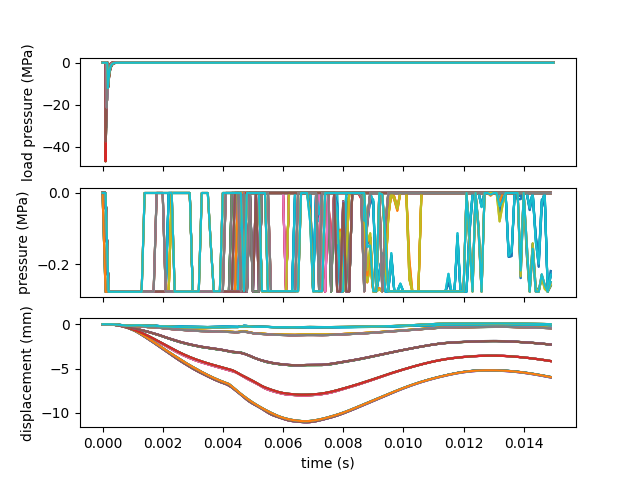

x_s_max_hf = 0.011052982403273988  # m


In [5]:
fig1, ax1 = plt.subplots(3, 1, sharex='col')
ax1 = ax1.flatten()

n_rows = 150
n_rows_load = 10*n_rows
for node_id in node_ids_load:
    ax1[0].plot(data_dicts_load[node_id]['time'][:n_rows_load], data_dicts_load[node_id]['pressure'][:n_rows_load])
    ax1[0].set_ylabel('load pressure (MPa)')

for node_id in node_ids:
    ax1[1].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['pressure'][:n_rows])
    ax1[1].set_ylabel('pressure (MPa)')
    ax1[2].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['displacement'][:n_rows])
    ax1[2].set_ylabel('displacement (mm)')
    ax1[2].set_xlabel('time (s)')
plt.show()

print(f"x_s_max_hf = {1e-3*np.max(np.abs(np.array([data_dicts[node_id]['displacement'] for node_id in node_ids]).ravel()))}  # m")

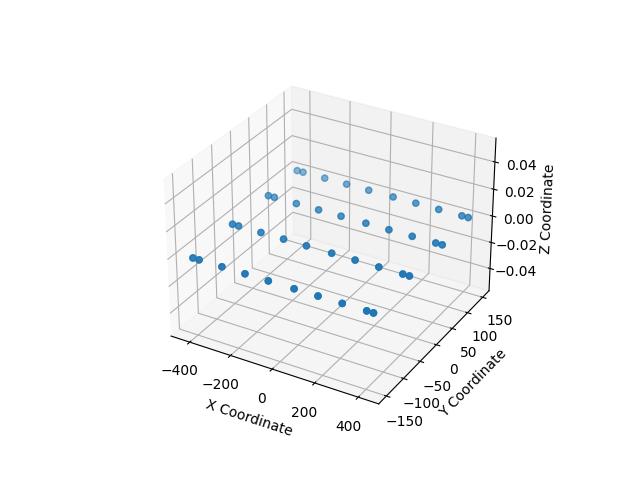

In [6]:
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# Set labels (optional)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

plt.show()

In [7]:
stride = 10

# Assuming data_dicts and node_ids are already defined
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])
displacement_data = np.array([data_dicts[node_id]['displacement'][:n_rows] for node_id in node_ids])
pressure_data = np.array([data_dicts[node_id]['pressure'][:n_rows] for node_id in node_ids])
time_data = np.array(data_dicts[node_ids[0]]['time'][:n_rows])

pressure_data_load = np.array([data_dicts_load[node_id]['pressure'][:n_rows_load] for node_id in node_ids_load])
time_data_load = np.array(data_dicts_load[node_ids_load[0]]['time'][:n_rows_load])

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Initialize scatter plot
# scat = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# # Set labels (optional)
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_zlabel('Z Coordinate')

# # Function to update the scatter plot
# def update(frame):
#     ax.clear()
#     ax.set_xlabel('X Coordinate')
#     ax.set_ylabel('Y Coordinate')
#     ax.set_zlabel('Z Coordinate')
#     ax.set_xlim([coordinates[:, 0].min(), coordinates[:, 0].max()])
#     ax.set_ylim([coordinates[:, 1].min(), coordinates[:, 1].max()])
#     ax.set_zlim([displacement_data.min(), displacement_data.max()])
#     ax.scatter(coordinates[:, 0], coordinates[:, 1], displacement_data[:, frame], c=pressure_data[:, frame], cmap='hot')
#     return scat,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=range(0, len(displacement_data[0]), stride), interval=1000/25, blit=False)

# HTML(ani.to_jshtml())


In [8]:
print(f'{time_data.shape=}')

time_data.shape=(150,)


In [9]:
print(f'{displacement_data.shape=}')

displacement_data.shape=(80, 150)


In [10]:
print(f'{pressure_data.shape=}')

pressure_data.shape=(80, 150)


In [11]:
print(f'{time_data_load.shape=}')

time_data_load.shape=(1500,)


In [12]:
print(f'{pressure_data_load.shape=}')

pressure_data_load.shape=(40, 1500)


# Train set generation from time history dataset

## Get maximum displacement and force

In [13]:
pressure_flag = 'mean' # 'max' # 

i_node_max = np.argmax(np.abs(np.max(np.abs(displacement_data), axis=1)))
disp = displacement_data[i_node_max, :]  # mm

length = 840
width = 300
print(f'{length=}, {width=}')
area = length*width

if pressure_flag == 'mean':
    force = np.mean(pressure_data, axis=0) * area  # MPa mm mm = 10e6 (N / m^2) (10e-3)^2 m^2 = N
elif pressure_flag == 'max':
    node_max_pressure = np.argmax(np.abs(np.mean(pressure_data, axis=1)))
    force = pressure_data[node_max_pressure, :] * area  # MPa mm mm = 10e6 (N / m^2) (10e-3)^2 m^2 = N
else:
    raise NotImplementedError
print(f'{disp.shape=}, {force.shape=}')



length=840, width=300
disp.shape=(150,), force.shape=(150,)


## Resampling to a constant delta_t

In [14]:
# Fix delta_t
delta_t_real = np.round(np.mean(np.diff(time_data)), 5)/100
print(f'{delta_t_real=}')

# New time vector
time_resampled_ = np.arange(time_data[0], time_data[-1], delta_t_real)

# Create an interpolation function
interp_disp_func = interp1d(time_data, disp, kind='cubic', fill_value="extrapolate")

interp_force_func = interp1d(time_data, force, kind='cubic', fill_value="extrapolate")


smoothing_window = 4

# Resample values using the interpolation function
disp_resampled_ = interp_disp_func(time_resampled_)
disp_resampled = signal.convolve(disp_resampled_, np.ones((smoothing_window))/smoothing_window, mode='valid')
force_resampled_ = interp_force_func(time_resampled_)
force_resampled = signal.convolve(force_resampled_, np.ones((smoothing_window))/smoothing_window, mode='valid')
time_resampled = time_resampled_[smoothing_window//2:-smoothing_window//2+1]


print(f'{time_resampled_.shape=}')
print(f'{time_resampled.shape=}')

print(f'{disp_resampled_.shape=}')
print(f'{disp_resampled.shape=}')
print(f'{force_resampled_.shape=}')
print(f'{force_resampled.shape=}')



delta_t_real=1e-06
time_resampled_.shape=(14900,)
time_resampled.shape=(14897,)
disp_resampled_.shape=(14900,)
disp_resampled.shape=(14897,)
force_resampled_.shape=(14900,)
force_resampled.shape=(14897,)


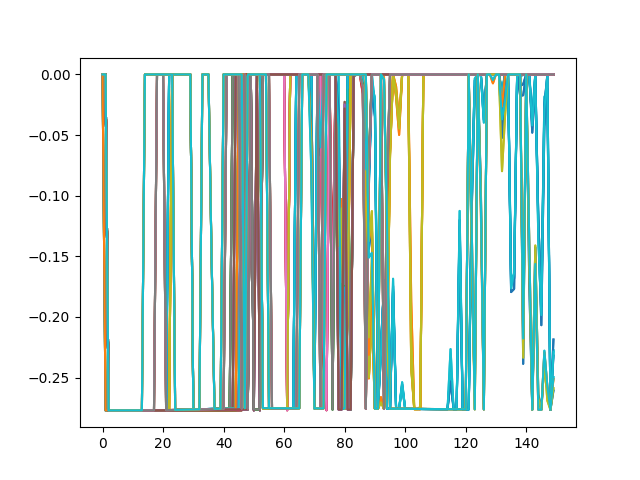

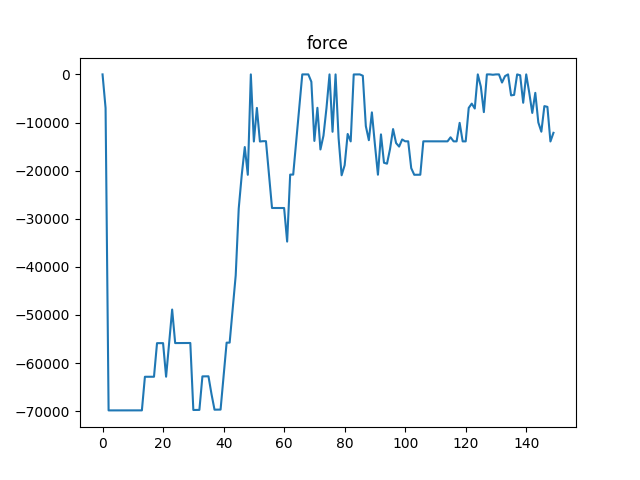

In [15]:
plt.figure()
plt.plot(pressure_data.T)
plt.show()

plt.figure()
plt.plot(force)
plt.title('force')
plt.show()


### Scaling

In [16]:
scales = {'time': 1e3,
          'force': 1e-7,
          'disp': 1e-2}


# Re-scale displacement
disp_resampled_norm = disp_resampled * scales['disp']

# Re-scale time vector for appropriate scaling
time_resampled_norm = time_resampled * scales['time']
delta_t_norm = time_resampled_norm[1] - time_resampled_norm[0]

# Re-scale force
force_resampled_norm = force_resampled * scales['force']

## Velocity estimation

In [17]:
vel_resampled_norm = np.diff(disp_resampled_norm, prepend=0)/delta_t_norm

## Acceleration estimation

In [18]:
acc_resampled_norm = np.diff(vel_resampled_norm, prepend=0)/delta_t_norm

In [19]:
disp_resampled_norm.shape

(14897,)

### Plots for inspecting resampling

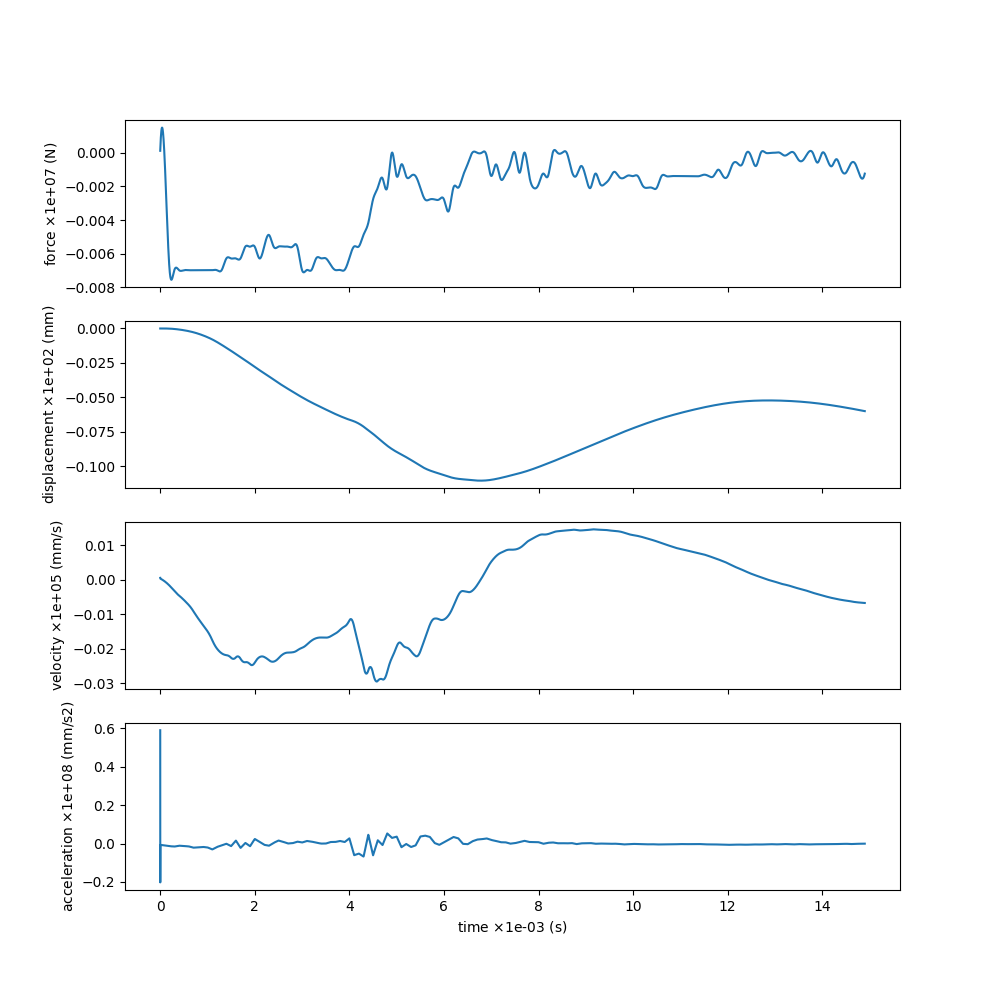

In [20]:
fig2, ax2 = plt.subplots(4, 1, figsize=(10,10), sharex='col')
ax2 = ax2.flatten()

ax2[0].plot(time_resampled_norm, force_resampled_norm.T)
ax2[0].set_ylabel(fr'force $\times${1/scales["force"]:.0e} (N)')
ax2[1].plot(time_resampled_norm, disp_resampled_norm.T)
ax2[1].set_ylabel(fr'displacement $\times${1/scales["disp"]:.0e} (mm)')
ax2[2].plot(time_resampled_norm, vel_resampled_norm.T)
ax2[2].set_ylabel(fr'velocity $\times${(1/scales["disp"])/(1/(scales["time"])):.0e} (mm/s)')
ax2[3].plot(time_resampled_norm, acc_resampled_norm.T)
ax2[3].set_ylabel(fr'acceleration $\times${(1/scales["disp"])/(1/(scales["time"]**2)):.0e} (mm/s2)')
ax2[3].set_xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')

plt.show()

# First approximation from full_iter = 0

In [21]:
# From full_iter = 0
m = 18.4035/100
c = 4205.9600/100000
k = 1042555.0104/(100000000)

print(f"Estimated mass (m): {m}")
print(f"Estimated damping (c): {c}")
print(f"Estimated stiffness (k): {k}")
print(f'damping ratio = {c/(2*m*np.sqrt(k/m))}')

Estimated mass (m): 0.184035
Estimated damping (c): 0.0420596
Estimated stiffness (k): 0.010425550104
damping ratio = 0.4801041276315337


### Verification

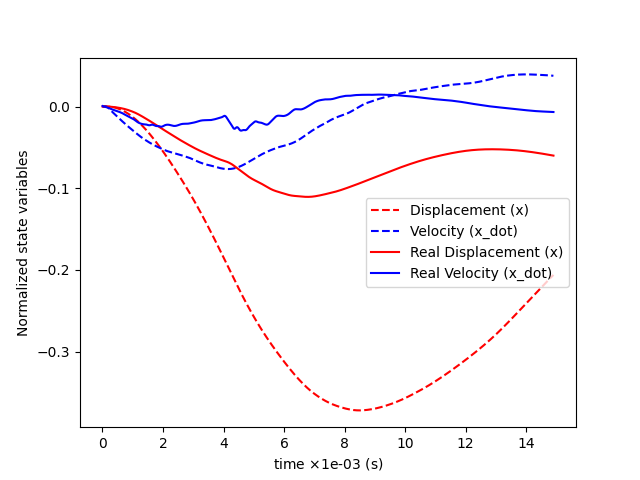

In [22]:
def solve_system(m, c, k, force, time):
    # Define the system dynamics
    def dynamics(y, f_t):
        x, x_dot = y
        x_ddot = (f_t - c * x_dot - k * x) / m
        return [x_dot, x_ddot]

    # Define the external force as a function of time 
    def force_t(t):
        return force.reshape((-1,1))[np.where(time > t)[0][0], :][0]

    # Wrapper for `solve_ivp` to include the force term
    def wrapped_dynamics(t, y, force_t):
        return dynamics(y, force_t(t))

    # Solve the ODE
    sol = solve_ivp(wrapped_dynamics, y0=np.zeros((2, )), t_span=[0, time[-2]], t_eval=time[:-2], args=[force_t])
    return sol

# Solve the system
sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)

# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], color='red', linestyle='--', label='Displacement (x)')
plt.plot(sol.t, sol.y[1], color='blue', linestyle='--', label='Velocity (x_dot)')
plt.plot(time_resampled_norm, disp_resampled_norm, color='red', linestyle='-', label='Real Displacement (x)')
plt.plot(time_resampled_norm, vel_resampled_norm, color='blue', linestyle='-', label='Real Velocity (x_dot)')
plt.xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')
plt.ylabel('Normalized state variables')
plt.legend()
plt.show()

## Refine model using Reinforcement Learning

In [23]:
from scipy.optimize import minimize, differential_evolution


# Save a copy of proxy
m_init, c_init, k_init = m, c, k

# Objective function to minimize
def objective(params, disp_resampled_norm, time_resampled_norm):
    # Unpack the parameters for this evaluation
    m, zeta, k = params
    c = zeta * 2 * m * np.sqrt(k/m)

    # Solve the system
    sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)
    
    try:
        error = np.sum(np.abs(sol.y[0] - disp_resampled_norm[:-2]))
        # error = np.sum((sol.y[0] - disp_resampled_norm[:-2])**2)
    except IndexError:
        error = np.inf

    return error

# Initial guess for m, c, k
initial_guess = [m_init, c_init, k_init]

# Optimize parameters

result = differential_evolution(objective, bounds=[(.10*m_init, 10*m_init), (0.0, 1.0), (.10*k_init, 10*k_init)], 
                                args=(disp_resampled_norm, time_resampled_norm), tol=1e-3, x0=(m_init, 0.5, k_init))

In [24]:
m, zeta, k = result.x
c = zeta * 2 * m * np.sqrt(k/m)
print(f"Optimized mass (m): {m}")
print(f"Optimized damping (c): {c}")
print(f"Optimized stiffness (k): {k}")
print(f'damping ratio = {c/(2*m*np.sqrt(k/m))}')

Optimized mass (m): 0.3174294256307222
Optimized damping (c): 0.16819086950758858
Optimized stiffness (k): 0.03708614202364812
damping ratio = 0.775073698857209


### Verification

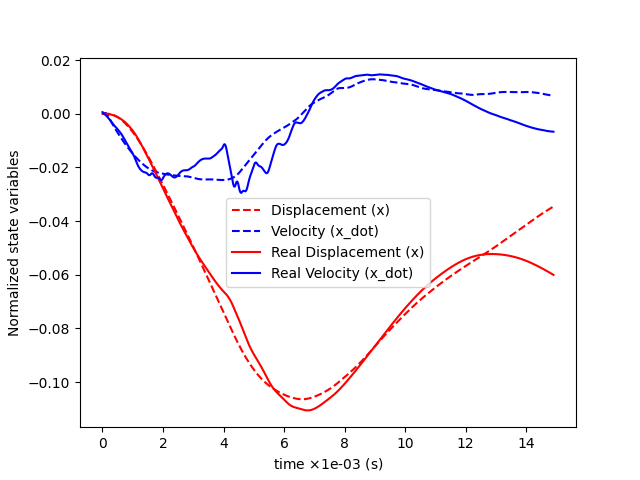

In [25]:
# Solve the system
sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)

# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], color='red', linestyle='--', label='Displacement (x)')
plt.plot(sol.t, sol.y[1], color='blue', linestyle='--', label='Velocity (x_dot)')
plt.plot(time_resampled_norm, disp_resampled_norm, color='red', linestyle='-', label='Real Displacement (x)')
plt.plot(time_resampled_norm, vel_resampled_norm, color='blue', linestyle='-', label='Real Velocity (x_dot)')
plt.xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')
plt.ylabel('Normalized state variables')
plt.legend()
plt.show()

# Back to physical units

In [26]:
m_Ton = m * (1/scales['force']) / ((1/scales['disp']) / (1/scales['time']**2)) 
c_Ns_mm = c * (1/scales['force']) / ((1/scales['disp']) / (1/scales['time']))
k_N_mm = k * (1/scales['force']) / (1/scales['disp'])
omega_rad_s = np.sqrt((k_N_mm*1000) / (m_Ton*1000))

print(f'{m_Ton=:.4f}, {c_Ns_mm=:.4f}, {k_N_mm=:.4f}')
print(f'm_s_ = {m_Ton*1000:.4f}  # kg')
print(f'k_s_ = {k_N_mm*1000:.4f} # N/m')
print(f'c_s_ = {c_Ns_mm*1000:.4f}  # Ns/m')
print(f'omega = {omega_rad_s=:.4f} rad/s')
print(f'frequency = {omega_rad_s/(2*np.pi)=:.4f} Hz')
print(f'period = {1/(omega_rad_s/(2*np.pi))=:.4f} s')
print(f'damping ratio = {(c_Ns_mm*1000)/(2*(m_Ton*1000)*omega_rad_s)}')

m_Ton=0.0317, c_Ns_mm=16.8191, k_N_mm=3708.6142
m_s_ = 31.7429  # kg
k_s_ = 3708614.2024 # N/m
c_s_ = 16819.0870  # Ns/m
omega = omega_rad_s=341.8080 rad/s
frequency = omega_rad_s/(2*np.pi)=54.4004 Hz
period = 1/(omega_rad_s/(2*np.pi))=0.0184 s
damping ratio = 0.775073698857209


## Equivalent force load
$$F=\frac{\sum_{i=0}^{n-1}{x_i(t_2) F_i}}{x_0(t_2)}$$

### Tribute areas

[    0.     0.  3000.  6000.  6000.  6000.  6000.  6000.  6000.  3000.
     0.     0.     0.     0.  3000.  6000.  6000.  6000.  6000.  6000.
  6000.  3000.     0.     0.  6000.  6000. 12000. 12000. 12000. 12000.
 12000. 12000. 12000. 12000. 12000. 12000. 12000. 12000.  6000.  6000.] 252000.0 252000


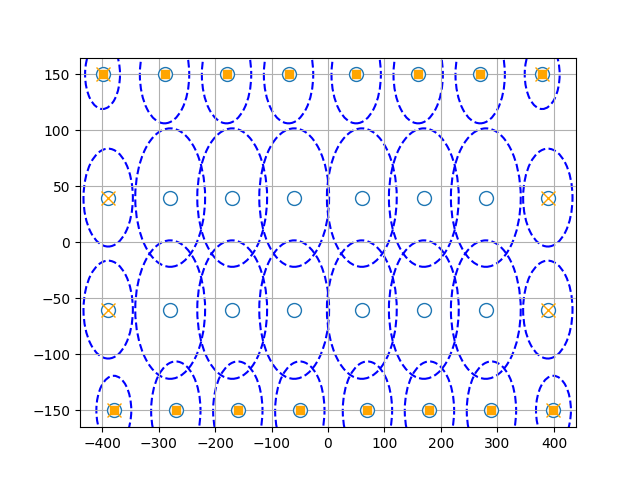

In [27]:
# Original coordinates
x_max = 420
x_min = -x_max
y_max = 150
y_min = -y_max
coordinates_load = np.array([data_dicts_load[node_id]['coordinates'] for node_id in node_ids_load])
points = {'valid': np.logical_and(coordinates_load[:, 0]>x_min*.955, coordinates_load[:, 0]<x_max*.955),
          'edge_x': np.logical_and(
              np.logical_or(coordinates_load[:, 0]<0.9*x_min, coordinates_load[:, 0]>0.9*x_max),
              np.logical_and(coordinates_load[:, 0]>x_min*.955, coordinates_load[:, 0]<x_max*.955)
          ),
          'edge_y': np.logical_and(
                np.logical_or(coordinates_load[:, 1]<0.9*y_min, coordinates_load[:, 1]>0.9*y_max),
                np.logical_and(coordinates_load[:, 0]>x_min*.955, coordinates_load[:, 0]<x_max*.955)
          ),
          'xy': coordinates_load[:, :2]}

areas = np.zeros(len(points['xy']))
for i, (valid, edge_x, edge_y) in enumerate(zip(points['valid'], points['edge_x'], points['edge_y'])):
    if valid:
        areas[i] = ((x_max-x_min)/3) * ((y_max-y_min)/7)
        if edge_x:
            areas[i] /= 2
        if edge_y:
            areas[i] /= 2

points['area'] = areas

print(points['area'], sum(points['area']), 300*840)

fig, ax = plt.subplots(1,1)
ax.grid()
ax.plot(points['xy'][points['valid']][:, 0], 
         points['xy'][points['valid']][:, 1], 
         linestyle='none', marker='o', markerfacecolor='w', markersize=10)
ax.plot(points['xy'][points['edge_x']][:, 0], 
         points['xy'][points['edge_x']][:, 1], 
         linestyle='none', marker='x', color='orange', markersize=10)
ax.plot(points['xy'][points['edge_y']][:, 0], 
         points['xy'][points['edge_y']][:, 1], 
         linestyle='none', marker='s', color='orange')
circle_radius = 20  # Set the circle radius
for (xi, yi), area in zip(points['xy'], points['area']):
    circle = plt.Circle((xi, yi), np.sqrt(area/np.pi), color="blue", 
                        fill=False, linestyle="--", linewidth=1.5)
    ax.add_artist(circle)
plt.show()

### Discrete forces $F_i$

In [28]:
points['pressure'], points['F_i'] = [], []
points['time'] = time_data_load
for i in range(len(points['xy'])):
    points['pressure'].append(pressure_data_load[i, :])  # MPa
    points['F_i'].append(pressure_data_load[i, :] * points['area'][i])  # N = MPa * mm2 <=> 1e6 * 1e-3 * 1e-3 = 1

### Equivalent force load $F$

Row index of the first +1 in any column: 137


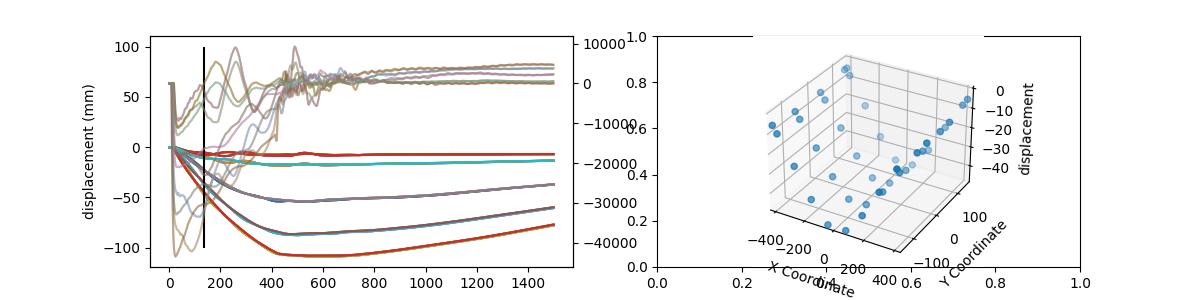

In [29]:
displacement_load_data = np.array([data_dicts_load[node_id]['displacement'][:n_rows_load] for node_id in node_ids_load])

# Before sign change in velocity
velocity_load_data = (np.diff(displacement_load_data.T, axis=0)/np.diff(time_data_load, axis=0).reshape((-1, 1))).T

# Function to find the first occurrence of +1 in any column
def find_first_plus_one_any_column(arr):
    # Find indices where the value is +1
    plus_one_indices = np.where(arr == 1)
    if plus_one_indices[0].size > 0:
        # Return the row index of the first occurrence
        return plus_one_indices[0][0]
    else:
        # Return -1 if +1 is not found in any column
        return -1

# Get the row index
tol = 100
frame = find_first_plus_one_any_column(np.sign(velocity_load_data.T - tol))

# Print the result
print("Row index of the first +1 in any column:", frame)

# Displacement of the front face just before change of sign in velocity
disp_before_compact = displacement_load_data[:, frame]


fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(displacement_load_data.T)
ax[0].vlines(frame, ymin=-100, ymax=100, color='black')
ax[0].twinx().plot(velocity_load_data.T, alpha=0.2)
ax[0].set_ylabel('displacement (mm)')

ax3d = fig.add_subplot(122, projection='3d')
ax3d.set_xlabel('X Coordinate')
ax3d.set_ylabel('Y Coordinate')
ax3d.set_zlabel('displacement')
ax3d.set_xlim([coordinates_load[:, 0].min(), coordinates_load[:, 0].max()])
ax3d.set_ylim([coordinates_load[:, 1].min(), coordinates_load[:, 1].max()])
ax3d.set_zlim([disp_before_compact.min(), 0.])
ax3d.scatter(coordinates_load[:, 0], coordinates_load[:, 1], disp_before_compact)

plt.show()

In [30]:
# Central node
i_central_node_load = np.argmin(np.sqrt((coordinates_load[:, 0] - 0)**2 + (coordinates_load[:, 1] - 0)**2))

# Load force calculation (equivalent work)
force_load = 0
for i, force in enumerate(points['F_i']):
    force_load += force * disp_before_compact[i]

force_load /= disp_before_compact[i_central_node_load]

### Approximate a triangle force load

force_load_resampled_.shape=(14900,)
force_load_resampled.shape=(14897,)

t_ini_=9.909927503774557e-05 s
T_ = 0.000129364752771688  # s
F_ = 4091928.2935113907  # N
Impulse: -264.67564602478814 Ns



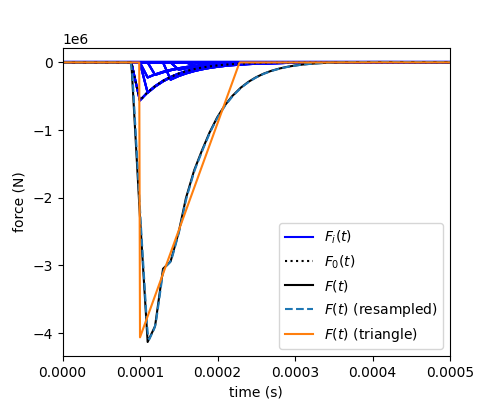

In [31]:
interp_force_load_func = interp1d(time_data_load, force_load, kind='linear', fill_value="extrapolate")
force_load_resampled_ = interp_force_load_func(time_resampled_)
force_load_resampled = signal.convolve(force_load_resampled_, np.ones((smoothing_window))/smoothing_window, mode='valid')
print(f'{force_load_resampled_.shape=}')
print(f'{force_load_resampled.shape=}')


def triangle_force(t_eval: float, t_ini: float, T: float, F: float) -> float:
    """
    Calculates the force with an instantaneous rise to F followed by a gradual 
    decrease over time T.
    
    Args:
        t_eval (float): The time at which the force is evaluated.
        t_ini (float): The start time of the force impulse.
        T (float): The total duration of the fall.
        F (float): The peak value of the force.
    
    Returns:
        float: The value of the force at time t_eval.
    """
    
    # Time elapsed since the start of the impulse
    delta_t = t_eval - t_ini

    if delta_t < 0 or delta_t > T:
        # Outside the force application period
        return 0.0
    elif delta_t == 0:
        # Instantaneous rise at the start
        return F
    else:
        # Gradual fall from F to 0 over time T
        return F * (1 - delta_t / T)

triangle_force_vectorized = np.vectorize(triangle_force)

# Detect the peak no mater whether is positive or negative
peak_idx = np.argmax(np.abs(force_load_resampled))
F_ = force_load_resampled[peak_idx]

def obj_triangle(params: list, t_vector: np.array, f_vector: np.array, F_):
    # Extract parameters to be optimized
    t_ini, T = params

    error = f_vector - triangle_force_vectorized(t_vector, t_ini, T, F_)
    return np.linalg.norm(error)

    
result_triangle = differential_evolution(obj_triangle, 
                                         [(0, 1e-3), (0, 1e-3)],
                                         args=(time_resampled, force_load_resampled, F_), disp=False)

t_ini_, T_ = result_triangle.x
print(f'\n{t_ini_=} s')
print(f'T_ = {T_}  # s')
print(f'F_ = {-F_}  # N')
print(f'Impulse: {F_*T_/2} Ns\n')

force_resampled_triangle = triangle_force_vectorized(time_resampled, t_ini_, T_, np.min(force_load_resampled))

# Plot for verification of proxy solution
plt.figure(figsize=(5,4))

for i, force in enumerate(points['F_i']):
    plt.plot(points['time'], force, color='blue')
plt.plot(points['time'], force, color='blue', label=r'$F_i(t)$')

plt.plot(points['time'], points['F_i'][i_central_node_load], linestyle=':', color='k', label=r'$F_0(t)$')
plt.plot(points['time'], force_load, color='k', label=r'$F(t)$')
plt.plot(time_resampled, force_load_resampled, linestyle='--', label=r'$F(t)$ (resampled)')
plt.plot(time_resampled, force_resampled_triangle, label=r'$F(t)$ (triangle)')

plt.xlim((0, .5e-3))
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend()
plt.show()

# Equivalent additional mass 
$$m_a = \frac{\sum_{i=0}^{n-1}{m_i v_i(t_1)}}{v_0(t_1)}$$

## Velocities after impulse

0.00022846402780943358 23


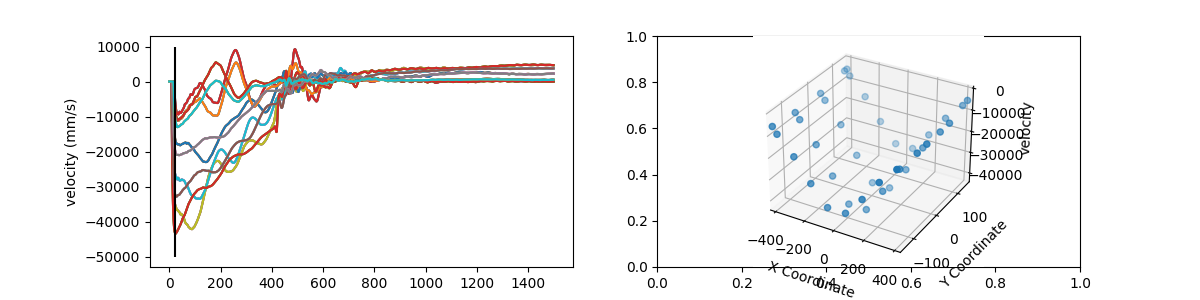

In [32]:
# Time just after load pulse
time_after_impulse = t_ini_ + T_
frame_after_impulse = np.argmin(np.abs(time_after_impulse - time_data_load))
print(time_after_impulse, frame_after_impulse)

vel_after_impulse = velocity_load_data[:, frame_after_impulse]

fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(velocity_load_data.T)
ax[0].set_ylabel('velocity (mm/s)')
ax[0].vlines(frame_after_impulse, ymin=-.5e5, ymax=1e4, color='black')

ax3d = fig.add_subplot(122, projection='3d')
ax3d.set_xlabel('X Coordinate')
ax3d.set_ylabel('Y Coordinate')
ax3d.set_zlabel('velocity')
ax3d.set_xlim([coordinates_load[:, 0].min(), coordinates_load[:, 0].max()])
ax3d.set_ylim([coordinates_load[:, 1].min(), coordinates_load[:, 1].max()])
ax3d.set_zlim([vel_after_impulse.min(), 0.])
ax3d.scatter(coordinates_load[:, 0], coordinates_load[:, 1], vel_after_impulse)

plt.show()

In [33]:
# Mass integration
sup_mass_dens_kg_m2 = 7850 * 4 * .0016
sup_mass_dens_kg_mm2 = sup_mass_dens_kg_m2 / 1e6

points['m_i'] = []
for i, area in enumerate(points['area']):
    points['m_i'].append(area*sup_mass_dens_kg_mm2)  # kg
    

## Equivalent additional mass

In [34]:
# Equivalent mass calculation (equivalent work)
m_a_eq = 0
for i, m_i in enumerate(points['m_i']):
    m_a_eq += m_i * vel_after_impulse[i]

m_a_eq /= vel_after_impulse[i_central_node_load]

print(f"Equivalent additional mass: \nm_a_ = {m_a_eq}  # kg")


Equivalent additional mass: 
m_a_ = 7.875188630289099  # kg


# Equivalence factor for yield force
$$f_\mathrm{eq}=\frac{f x_0(t_2) n}{\sum_{i=0}^{n-1}{x_i(t_2)}}= \phi_\mathrm{eq} f$$

In [35]:
phi_eq = disp_before_compact[i_central_node_load] * len(disp_before_compact) / sum(disp_before_compact)
print(f"Equivalence factor for yield force: \nphi_eq = {phi_eq} ")


Equivalence factor for yield force: 
phi_eq = 1.8354678011326788 
